In [163]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geopy import geocoders
import time

In [164]:
test = {'latitude': np.nan, 'longitude': np.nan}
ser = pd.Series(test)

In [165]:
ser.latitude

nan

In [166]:
ser

latitude    NaN
longitude   NaN
dtype: float64

In [167]:
def get_location_by_address(address):
    """This function returns a location as raw from an address
    will repeat until success"""
    geolocator = geocoders.GoogleV3(api_key="") #INSERT API KEY HERE
    location = geolocator.geocode(address, timeout = 10)
    if location is not None:
        return location
    else:
        test = {'latitude': np.nan, 'longitude': np.nan}
        ser = pd.Series(test)
        return ser

## Read raw CLUES database

In [168]:
df = pd.read_csv('/home/jovyan/work/data/external/CLUES_csv.csv', encoding='ISO-8859-1')
df.columns= df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
print(df.shape)
df.head(3)

(41753, 82)


/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (32,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ï»¿id,clues,nombre_de_la_entidad,clave_de_la_entidad,nombre_del_municipio,clave_del_municipio,nombre_de_la_localidad,clave_de_la_localidad,nombre_de_la_jurisdiccion,clave_de_la_jurisdiccion,...,clave_tipo_obra,horario_de_atencion,areas_y_servicios,ultimo_movimiento,fecha_ultimo_movimiento,motivo_baja,fecha_efectiva_de_baja,certificacion_csg,tipo_certificacion,vigencia_certificacion
0,9702,HGSMP000490,HIDALGO,13,CHILCUAUTLA,19,CHILCUAUTLA,1,IXMIQUILPAN,6,...,6.0,NaN,NaN,CAMBIO,2016-05-25,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN
1,74814,ASSMP000955,AGUASCALIENTES,1,AGUASCALIENTES,1,AGUASCALIENTES,1,AGUASCALIENTES,1,...,6.0,NaN,NaN,ALTA,2021-03-10,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN
2,74815,BCSMP005862,BAJA CALIFORNIA,2,MEXICALI,2,MEXICALI,1,MEXICALI,1,...,6.0,NaN,NaN,ALTA,2021-03-10,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN


In [169]:
print('Number of CLUES = ', len(df))

Number of CLUES =  41753


In [170]:
missingx = df[['longitud']].isna().sum()
missingy = df[['latitud']].isna().sum()

print('Missing: ', missingx, missingy)

Missing:  longitud    884
dtype: int64 latitud    884
dtype: int64


In [171]:
#Filter CLUES, take out those not in operation. Keep Only in Operation and pending.
df1 = df[df['estatus_de_operacion']== 'EN OPERACION']
df2 = df[df['estatus_de_operacion']== 'PENDIENTE DE ENTRAR EN OPERACION']
clues = df1.append(df2)

In [172]:
print('CLUES in operation: ' + str(len(df1)) + ' CLUES pending: ' +str(len(df2)) + ' TOTAL: ' + str(len(clues)))

CLUES in operation: 35814 CLUES pending: 40 TOTAL: 35854


In [173]:
clues = clues.set_index('clues')
clues.head(2)

,ï»¿id,nombre_de_la_entidad,clave_de_la_entidad,nombre_del_municipio,clave_del_municipio,nombre_de_la_localidad,clave_de_la_localidad,nombre_de_la_jurisdiccion,clave_de_la_jurisdiccion,nombre_de_la_institucion,...,clave_tipo_obra,horario_de_atencion,areas_y_servicios,ultimo_movimiento,fecha_ultimo_movimiento,motivo_baja,fecha_efectiva_de_baja,certificacion_csg,tipo_certificacion,vigencia_certificacion
clues,,,,,,,,,,,,,,,,,,,,,
HGSMP000490,9702,HIDALGO,13,CHILCUAUTLA,19,CHILCUAUTLA,1,IXMIQUILPAN,6,SERVICIOS MEDICOS PRIVADOS,...,6.0,NaN,NaN,CAMBIO,2016-05-25,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN
ASSMP000955,74814,AGUASCALIENTES,1,AGUASCALIENTES,1,AGUASCALIENTES,1,AGUASCALIENTES,1,SERVICIOS MEDICOS PRIVADOS,...,6.0,NaN,NaN,ALTA,2021-03-10,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN


In [174]:
clues_w = clues[clues['longitud']<= -100]
clues_e = clues[clues['longitud']> -100]
clues_nan = clues[clues['longitud'].isna()]
clues_nan2 = clues[clues['latitud'].isna()]

In [175]:
clues_nan.equals(clues_nan2)

True

In [176]:
countx = 0
county = 0
missing = pd.DataFrame()
complete = pd.DataFrame()
for idx,row in clues_w.iterrows():
    x = len(str(clues.loc[ idx, 'longitud']))
    if x< 8:
        countx = countx+1
    y = len(str(clues.loc[ idx, 'latitud']))
    if y< 6:
        county = county+1
    if x<8 or y<6:
        app = clues.loc[[idx]]
        missing = missing.append(app)
    if x>=8 and y>=6:
        comp = clues.loc[[idx]]
        complete = complete.append(comp)

In [177]:
for idx,row in clues_e.iterrows():
    x = len(str(clues.loc[ idx, 'longitud']))
    if x< 8:
        countx = countx+1
    y = len(str(clues.loc[ idx, 'latitud']))
    if y< 6:
        county = county+1
    if x<7 or y<6:
        app = clues.loc[[idx]]
        missing = missing.append(app)
    if x>=7 and y>=6:
        comp = clues.loc[[idx]]
        complete = complete.append(comp)

In [178]:
missing = missing.append(clues_nan)

In [179]:
print('TOT: ' + str(len(clues)) + ' MISSING: ' + str(len(missing)) + ' COMPLETE: ' + str(len(complete)))

TOT: 35854 MISSING: 1287 COMPLETE: 34567


In [180]:
len(missing) + len(complete)

35854

In [181]:
complete['address'] = (complete['numero_exterior'] + ' ' + complete['vialidad'] +  ', ' + 
    complete['nombre_del_municipio'] + ', ' + complete['nombre_de_la_entidad']
     + ', MEXICO')
missing['address'] = (missing['numero_exterior'] + ' ' + missing['vialidad'] +  ', ' + 
    missing['nombre_del_municipio'] + ', ' + missing['nombre_de_la_entidad']
     + ', MEXICO')

In [182]:
print ('CLUES with coordinates: ' + str(len(complete)) + 
    ' CLUES without coordinates or lack of precision: ' + str(len(missing)))

CLUES with coordinates: 34567 CLUES without coordinates or lack of precision: 1287


In [183]:
missingvalid = missing[missing['address'].notna()]
print ('Missing CLUES with a valid address to look for: ' + str(len(missingvalid)))

Missing CLUES with a valid address to look for: 585


In [184]:
len(missingvalid[missingvalid['longitud'].isna()])

252

In [217]:
complete.latitud.CHSDN000043

20.619997

In [187]:
finderror = missingvalid.copy()
finderror.reset_index(inplace = True)

In [188]:
finderror.loc[135, 'address']

'POSTE NO.26 NInOS HeROES, EL FUERTE, SINALOA, MEXICO'

In [189]:
count = 0
good = 0
for idx,row in missingvalid.iterrows():
    address = missingvalid.loc[idx, 'address']
    location = get_location_by_address(address)
    latitude = location.latitude
    longitude = location.longitude
    if pd.notna(latitude):
        good = good + 1
        missingvalid.loc[idx, 'latitud'] = latitude
        missingvalid.loc[idx, 'longitud'] = longitude
    count = count +1
    print(str(count) + '/' + str(len(missingvalid)))

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


1/585
2/585
3/585
4/585
5/585
6/585
7/585
8/585
9/585
10/585
11/585
12/585
13/585
14/585
15/585
16/585
17/585
18/585
19/585
20/585
21/585
22/585
23/585
24/585
25/585
26/585
27/585
28/585
29/585
30/585
31/585
32/585
33/585
34/585
35/585
36/585
37/585
38/585
39/585
40/585
41/585
42/585
43/585
44/585
45/585
46/585
47/585
48/585
49/585
50/585
51/585
52/585
53/585
54/585
55/585
56/585
57/585
58/585
59/585
60/585
61/585
62/585
63/585
64/585
65/585
66/585
67/585
68/585
69/585
70/585
71/585
72/585
73/585
74/585
75/585
76/585
77/585
78/585
79/585
80/585
81/585
82/585
83/585
84/585
85/585
86/585
87/585
88/585
89/585
90/585
91/585
92/585
93/585
94/585
95/585
96/585
97/585
98/585
99/585
100/585
101/585
102/585
103/585
104/585
105/585
106/585
107/585
108/585
109/585
110/585
111/585
112/585
113/585
114/585
115/585
116/585
117/585
118/585
119/585
120/585
121/585
122/585
123/585
124/585
125/585
126/585
127/585
128/585
129/585
130/585
131/585
132/585
133/585
134/585
135/585
136/585
137/585
138/585
139/

In [190]:
good

585

In [191]:
len(missingvalid[missingvalid['longitud'].isna()])

0

In [192]:
missingvalid.latitud

clues
GRIST000083    17.008371
MNIST000074    18.617276
CMSSA001180    18.920182
MCSSA018593    19.045249
CMIMS000075    19.090987
                 ...    
VZPMX000141    18.827848
VZPMX000165    18.772742
DFSMP005550    19.419900
SLSSA003775    23.942068
TCSMP000332    18.395166
Name: latitud, Length: 585, dtype: float64

In [193]:
found = missingvalid[missingvalid['latitud'].notna()]

In [194]:
len(found)

585

In [195]:
len(complete)

34567

In [196]:
complete = complete.append(found)

In [197]:
len(complete)

35152

In [198]:
complete.to_excel('CorrectedCLUES.xlsx')

In [199]:
complete.to_csv('CorrectedCLUES_csv.csv')

In [200]:
complete.columns.to_list()

['ï»¿id',
 'nombre_de_la_entidad',
 'clave_de_la_entidad',
 'nombre_del_municipio',
 'clave_del_municipio',
 'nombre_de_la_localidad',
 'clave_de_la_localidad',
 'nombre_de_la_jurisdiccion',
 'clave_de_la_jurisdiccion',
 'nombre_de_la_institucion',
 'clave_de_la_institucion',
 'nombre_tipo_establecimiento',
 'clave_tipo_establecimiento',
 'nombre_de_tipologia',
 'clave_de_tipologia',
 'nombre_de_subtipologia',
 'clave_de_subtipologia',
 'clave_scian',
 'descripcion_clave_scian',
 'consultorios_de_med_gral',
 'consultorios_en_otras_areas',
 'total_de_consultorios',
 'camas_en_area_de_hos',
 'camas_en_otras_areas',
 'total_de_camas',
 'nombre_de_la_unidad',
 'clave_de_vialidad',
 'tipo_de_vialidad',
 'vialidad',
 'numero_exterior',
 'numero_interior',
 'clave_del_tipo_de_asentamiento',
 'tipo_de_asentamiento',
 'asentamiento',
 'entre_tipo_de_vialidad_1',
 'entre_vialidad_1',
 'entre_tipo_de_vialidad_2',
 'entre_vialidad_2',
 'observaciones_de_la_direccion',
 'codigo_postal',
 'estatus_d

## Data treatment

### Treat longitud and latitude

In [201]:
df_tmp = complete.copy()

variables = ['latitud','longitud']

for var in variables:
    i = 0
    for x in df_tmp[var]:
        
        try:
            x_float = float(x)
            
            if x_float > 0 and var=='longitud':
                x_float = x_float*-1
                
            if (x_float>-80 or x_float<-140) and var=='longitud':
                df_tmp[var].iloc[i] = np.nan
            elif (x_float>35 or x_float<10) and var=='latitud':
                df_tmp[var].iloc[i] = np.nan
            else:
                df_tmp[var].iloc[i] = x_float
                
            i += 1
        except:
            try:
                x_float = float(x[:x.find(' ')])
                if x_float > 0 and var=='longitud':
                    x_float = x_float*-1
                df_tmp[var].iloc[i] = x_float
                i += 1
            except:
                try:
                    degree= float(x[:x.find('°')])
                    minutes = float(x[(x.find('°')+1):(x.find('\''))])
                    seconds= float(x[x.find('\'')+1:(x.find('"'))])
                    x_float=degree + minutes/60 + seconds/60
                    if x_float > 0 and var=='longitud':
                        x_float = x_float*-1
                    df_tmp[var].iloc[i] = x_float
                    i += 1
                except:
                    if (var=='latitud' and i==19855) or (var=='longitud' and i==16200):
                        x_float = float(x[:x.find('.')+4])
                        df_tmp[var].iloc[i] = x_float
                    elif var=='longitud' and i==29597:
                        df_tmp[var].iloc[i] = -97.426111
                    elif var=='longitud' and i==31691:
                        element = '-107°26\'3.10'
                        degree= float(element[:element.find('°')])
                        minutes = float(element[(element.find('°')+1):(element.find('\''))])
                        seconds= float(element[element.find('\'')+1:])
                        x_float=degree + minutes/60 + seconds/60
                        df_tmp[var].iloc[i] = x_float
                    elif var=='latitud' and i==31691:
                        element = '24°47\'53.26'
                        degree= float(element[:element.find('°')])
                        minutes = float(element[(element.find('°')+1):(element.find('\''))])
                        seconds= float(element[element.find('\'')+1:])
                        x_float=degree + minutes/60 + seconds/60
                        df_tmp[var].iloc[i] = x_float
                    else:
                        print(x,i,var)
                    i += 1

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [202]:
isna = []

for var in variables:
    i = 0
    for x in df_tmp[var]:
        if pd.isna(x):
            if i not in isna:
                isna.append(i)
                i+= 1
            else:
                i+= 1
        else:
            i+=1

In [203]:
len(isna)

1

### To GeoDataFrame

In [204]:
gdf = gpd.GeoDataFrame(
    df_tmp, geometry=gpd.points_from_xy(df_tmp.longitud, df_tmp.latitud))
print(gdf.shape)
gdf.head(2)

(35152, 83)


,ï»¿id,nombre_de_la_entidad,clave_de_la_entidad,nombre_del_municipio,clave_del_municipio,nombre_de_la_localidad,clave_de_la_localidad,nombre_de_la_jurisdiccion,clave_de_la_jurisdiccion,nombre_de_la_institucion,...,areas_y_servicios,ultimo_movimiento,fecha_ultimo_movimiento,motivo_baja,fecha_efectiva_de_baja,certificacion_csg,tipo_certificacion,vigencia_certificacion,address,geometry
clues,,,,,,,,,,,,,,,,,,,,,
GRSSA002723,7439,GUERRERO,12,COYUCA DE BENITEZ,21,LOS MOGOTES,35,COSTA GRANDE,5,SECRETARIA DE SALUD,...,NaN,CAMBIO,2005-12-31,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN,NaN,POINT (-100.07510 16.94084)
GRSSA002641,7431,GUERRERO,12,COYUCA DE BENITEZ,21,LA BARRA (LA BARRA DE COYUCA),9,COSTA GRANDE,5,SECRETARIA DE SALUD,...,NaN,CAMBIO,2005-12-31,NaN,NaN,NO CERTIFICADO,NO ESPECIFICADO,NaN,NaN,POINT (-100.10340 16.94742)


GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

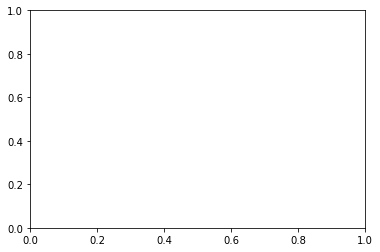

In [205]:
gdf_ = gdf[~gdf.index.isin(isna)].copy()
gdf_ = gdf_.set_crs("EPSG:4326")
gdf_.plot()

In [206]:
df_missing = gdf.loc[gdf.index.isin(isna)][['nombre_de_la_entidad','clave_de_la_entidad']]
df_missing = df_missing.groupby('nombre_de_la_entidad').count()
df_missing.head(2)

,clave_de_la_entidad
nombre_de_la_entidad,


In [207]:
df_loc = gdf_[['nombre_de_la_entidad','clave_de_la_entidad']].groupby('nombre_de_la_entidad').count()
df_loc.head(2)

,clave_de_la_entidad
nombre_de_la_entidad,
AGUASCALIENTES,271
BAJA CALIFORNIA,864


In [208]:
df_pct_missing = df_missing.reset_index().merge(df_loc.reset_index(), on='nombre_de_la_entidad')
df_pct_missing['pct_missing'] = 100 * (df_pct_missing['clave_de_la_entidad_x'] / df_pct_missing['clave_de_la_entidad_y'])
df_pct_missing

,clave_de_la_entidad_x,nombre_de_la_entidad,clave_de_la_entidad_y,pct_missing
